In [1]:
import pymt.models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
sns.set(style='whitegrid', font_scale= 1.2)

➡ models: GIPL, ECSimpleSnow


In [2]:
ec = pymt.models.ECSimpleSnow()
print(ec.get_component_name())
# List input and output variable names.
print(ec.get_output_var_names())
print(ec.get_input_var_names())

The 1D Snow Model
('snowpack__depth', 'snowpack__mass-per-volume_density')
('precipitation_mass_flux', 'land_surface_air__temperature', 'precipitation_mass_flux_adjust_factor', 'snow_class', 'open_area_or_not', 'snowpack__initial_depth', 'snowpack__initial_mass-per-volume_density')


In [3]:
gipl = pymt.models.GIPL()
print(gipl.get_component_name())

# List input and output variable names.
print(gipl.get_output_var_names())
print(gipl.get_input_var_names())

The 1D GIPL Model
('soil__temperature', 'model_soil_layer__count')
('land_surface_air__temperature', 'snowpack__depth', 'snow__thermal_conductivity', 'soil_water__volume_fraction', 'soil_unfrozen_water__a', 'soil_unfrozen_water__b')


In [4]:
defaults = ec.setup('.')
print(defaults)

('snow_model.cfg', '/Users/kangwang/Documents/GitHub/GIPL_BMI_Fortran/Notebooks')


In [5]:
defaults = gipl.setup('.')
print(defaults)

('gipl_config.cfg', '/Users/kangwang/Documents/GitHub/GIPL_BMI_Fortran/Notebooks')


In [6]:
ec.initialize('snow_model.cfg')

In [7]:
gipl.initialize('gipl_config.cfg')

In [8]:
# List input and output variable names.
print(gipl.get_output_var_names())
print(gipl.get_input_var_names())

# Get soil depth: [unit: m]
depth = gipl.get_grid_z(2)
n_depth = int(len(depth))

('soil__temperature', 'model_soil_layer__count')
('land_surface_air__temperature', 'snowpack__depth', 'snow__thermal_conductivity', 'soil_water__volume_fraction', 'soil_unfrozen_water__a', 'soil_unfrozen_water__b')


In [9]:
# Get the length of forcing data:
ntime = int(gipl.bmi.get_end_time())

# Define a variable to store soil temperature through the time period

tsoil = np.zeros((n_depth, ntime)) * np.nan

print('Final soil temperatures will be ', tsoil.shape)

Final soil temperatures will be  (176, 365)


[-25.555555] [ 0.18039082] [ 0.2737514]


Text(0.5, 1.0, 'Ground Temperatures (GIPL output)')

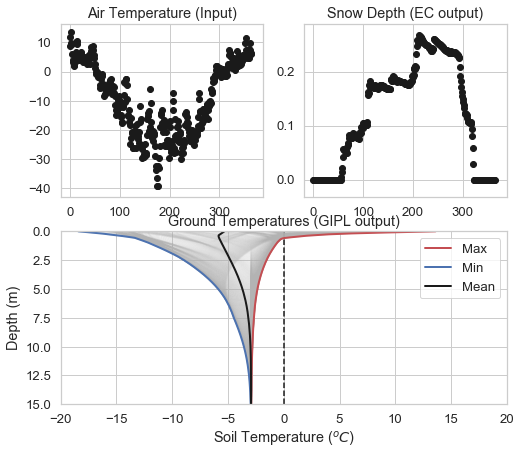

In [10]:
fig = plt.figure(figsize=[8,7])

ax2 = fig.add_subplot(2,2,1)
ax2.set_title('Air Temperature (Input)')
ax3 = fig.add_subplot(2,2,2)
ax3.set_title('Snow Depth (EC output)')

ax1 = fig.add_subplot(2,2,(3,4))
ax1.set_ylim([15,0])
ax1.set_xlim([-20,20])
ax1.set_xlabel('Soil Temperature ($^oC$)')
ax1.set_ylabel('Depth (m)')
ax1.plot([0,0],[15,0],'k--')

for i in np.arange(365):
    
    ec.update()
    
    tair  = ec.get_value('land_surface_air__temperature')    
    snd   = ec.get_value('snowpack__depth', units='m')
    rsn   = ec.get_value('snowpack__mass-per-volume_density', units = 'g cm-3')
    
    if i == 180:
        
        print(tair, snd, rsn)
    
    gipl.set_value('land_surface_air__temperature', tair)
    gipl.set_value('snowpack__depth', snd)
    gipl.set_value('snow__thermal_conductivity', rsn * rsn * 2.846)
    
    gipl.update()
    
    tsoil[:,i] = gipl.get_value('soil__temperature')
    
    ax1.plot(tsoil[depth>=0,i], depth[depth>=0],color = [0.7,0.7,0.7], alpha = 0.1)
    
    ax2.scatter(i, tair, c = 'k')
    ax3.scatter(i, snd , c = 'k')
    
#     print(tair, snd, rsn)

ax1.plot(tsoil[depth>=0,:].max(axis=1), depth[depth>=0], 'r', linewidth = 2, label = 'Max')
ax1.plot(tsoil[depth>=0,:].min(axis=1), depth[depth>=0], 'b', linewidth = 2, label = 'Min')
ax1.plot(tsoil[depth>=0,:].mean(axis=1), depth[depth>=0], 'k', linewidth = 2, label = 'Mean')
ax1.legend()
ax1.set_title('Ground Temperatures (GIPL output)')

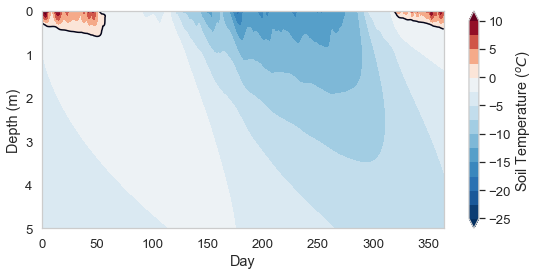

In [11]:
fig = plt.figure(figsize=[9,4])
divnorm = mcolors.DivergingNorm(vmin=-25., vcenter=0., vmax=10)
plt.contourf(np.arange(ntime), depth, tsoil, np.linspace(-25,10,15), 
             norm = divnorm,
             cmap="RdBu_r", extend = 'both')

plt.ylim([5,0])
cb = plt.colorbar()
plt.xlabel('Day')
plt.ylabel('Depth (m)')
cb.ax.set_ylabel('Soil Temperature ($^oC$)')

plt.contour(np.arange(ntime), depth, tsoil, [0]) # ZERO 